In [1]:
# Importing necessary libraries 

import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

import findspark
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

import os, sys, shutil
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud


from pyspark.ml.feature import NGram
from pyspark.ml.feature import HashingTF, IDF

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [2]:
# Importing the dataset

dataset = pd.read_csv('./Consumer_complaints.csv')

In [3]:
# Viewing the data

dataset.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-12-20,"Money transfer, virtual currency, or money service",Domestic (US) money transfer,Fraud or scam,NaN,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,WELLS FARGO & COMPANY,NaN,NaN,Older American,Consent not provided,Web,2022-12-20,Closed with explanation,Yes,NaN,6342692
1,2022-12-20,"Money transfer, virtual currency, or money service",Mobile or digital wallet,Fraud or scam,NaN,NaN,NaN,"Early Warning Services, LLC",IL,61107.0,NaN,NaN,Web,2022-12-20,Closed with explanation,Yes,NaN,6342336
2,2022-12-21,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,WELLS FARGO & COMPANY,NY,11224.0,NaN,Consent not provided,Web,2022-12-21,Closed with explanation,Yes,NaN,6341313
3,2022-12-23,"Money transfer, virtual currency, or money service",Domestic (US) money transfer,Other transaction problem,NaN,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",NY,11101.0,NaN,Consent not provided,Web,2022-12-23,Closed with explanation,Yes,NaN,6356774
4,2022-12-23,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Card opened as result of identity theft or fraud,NaN,NaN,ENCORE CAPITAL GROUP INC.,MT,59037.0,NaN,NaN,Web,2022-12-23,Closed with non-monetary relief,Yes,NaN,6354973


In [4]:
# Keeping only relevant features 

dataset = dataset.loc[:, ['Date received', 'Product', 'Consumer complaint narrative', 'Company response to consumer', 'Timely response?']]

In [5]:
# Filtering out not null consumer complaints  

df = dataset.loc[dataset['Consumer complaint narrative'].notnull(), :]
df.reset_index(drop = True, inplace = True)
df.head()

,Date received,Product,Consumer complaint narrative,Company response to consumer,Timely response?
0,2022-12-14,Checking or savings account,"This is a youth checking account that converted to a regular checking upon the child turning XXXX. Mom is listed as an account holder still. Unauthorized account charges from XXXX have occurred. Usaa will not speak to the mom or child on the account and has not addressed the charges. Thus is due to not being able to authenticate the child who has limited info in XXXX XXXX and has issues accessing the site. Usaa refused tech support requests, etc",Closed with explanation,Yes
1,2022-11-24,Credit card or prepaid card,"A fraudulent charge was made on the card and soon after reported. The fraudulent claim was denied and claimed the item was delivered to my address, which is false. \n\nI never made a purchase anywhere near the date of the transaction and never received a delivery after the date of the transaction. \n\nI was never contacted during the investigation and was only sent a denial letter. \n\nThe card is less than a year old and all purchases were made either online or at our local XXXX 's store. T...",Closed with explanation,Yes
2,2022-12-16,Credit card or prepaid card,CITIs Best Buy credit card automatically enrolled me in a debt protection program. I asked for proof of me accepting this enrollment and they could not provide this. Their response was that it appears on the statement which is accurate. It is also accurate that they asked me to enroll in paperless and I was happy to do that. It is also true that the functionality to view or download statements does not work on mobile devices. I will provide screenshots of the link I clicked and the error I r...,Closed with explanation,Yes
3,2022-12-10,Checking or savings account,XX/XX/2022. I began noticing charges to my debit card and changes to my online Wells Fargo account .I have been issues 4 debit cards and now Wells Fargo refuses to issue a new debit card and suspended my online service .My arm pin keeps getting changed and I can not stop the fraud charges.,Closed with explanation,Yes
4,2022-12-20,Checking or savings account,"My husband and I have separate addresses due to personal problems. We have had a joint account for years before the separate addresses that I don't use. Because of my credit problems I filed a bankruptcy, he did not. I have not worked in years, he's the one who works and makes deposits into this account. Wells Fargo went in and froze my husband 's account with almost {$8000.00} in it. My husband is blaming me and is very upset. My attorney said my bankruptcy would not affect my husband in a...",Closed with explanation,Yes


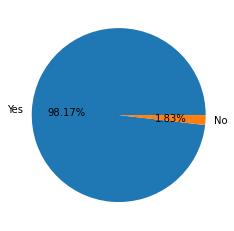

In [6]:
# Pie Chart for timely response

plt.pie(df['Timely response?'].value_counts(), labels = df['Timely response?'].value_counts().index, autopct = '%0.02f%%')
plt.show()

### Lets split the dataset based on the timely response 

Assuming the tickets where timely responses were 'No' to have escalated later on, we will use this data later on to check whether these tickets were not resolved on time due to incorrect ticket assignments to their respective categories(product).

df_main contains tickets which were resolved on time.

df_aux contains tickets which were not resolved and escalated

In [7]:
df_main = df[df['Timely response?'] == 'Yes']
df_aux = df[df['Timely response?'] == 'No']

In [8]:
# Shape of both datasets
df_main.shape, df_aux.shape

((354902, 5), (6620, 5))

In [9]:
# Checking for null values

df_main.isnull().sum()

Date received                   0
Product                         0
Consumer complaint narrative    0
Company response to consumer    1
Timely response?                0
dtype: int64

We have 1 null values in Company response to consumer

In [10]:
df_main.dropna(inplace= True)

In [11]:
df_main.duplicated().sum()

3878

There are 3878 duplicated tickets. Lets remove it

In [12]:
df_main.drop_duplicates(ignore_index = True, inplace = True)

In [13]:
# Shape of dataset after removing null and duplicated values

print('Final shape of dataset: ')
print(df_main.shape)

Final shape of dataset: 
(351023, 5)


In [14]:
# Descriptive Statistics 

df_main.describe()

,Date received,Product,Consumer complaint narrative,Company response to consumer,Timely response?
count,351023,351023,351023,351023,351023
unique,1813,9,343397,4,1
top,2022-06-28,Credit card or prepaid card,I see multiple 30-60 days late marks which is a clear violation of my right under the FCRA. The company has never responded to any of my attempts to obtain any proof or documentation that will prove this account is being reported accurately.,Closed with explanation,Yes
freq,480,74923,164,285213,351023


In [15]:
# Checking datatypes of the features

df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351023 entries, 0 to 351022
Data columns (total 5 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 351023 non-null  object
 1   Product                       351023 non-null  object
 2   Consumer complaint narrative  351023 non-null  object
 3   Company response to consumer  351023 non-null  object
 4   Timely response?              351023 non-null  object
dtypes: object(5)
memory usage: 13.4+ MB


In [16]:
# Typecasting 

df_main['Date received'] = pd.to_datetime(df_main['Date received'])

# Exploratory Data Analysis

In [17]:
# Lets check the number of product categories in the dataset

print(f'Total number of unique Products: {df_main.Product.nunique()}\n')
print(df_main.Product.unique())

Total number of unique Products: 9

['Checking or savings account' 'Credit card or prepaid card' 'Mortgage'
 'Vehicle loan or lease' 'Payday loan, title loan, or personal loan'
 'Money transfer, virtual currency, or money service' 'Student loan'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection']


In [18]:
# Percentage of tickets for each product

np.round((df_main.Product.value_counts()/ df_main.Product.shape[0])*100, 2)

Credit card or prepaid card                                                     21.34
Credit reporting, credit repair services, or other personal consumer reports    16.49
Mortgage                                                                        16.10
Checking or savings account                                                     14.46
Debt collection                                                                 11.19
Money transfer, virtual currency, or money service                               7.08
Vehicle loan or lease                                                            5.09
Student loan                                                                     4.96
Payday loan, title loan, or personal loan                                        3.28
Name: Product, dtype: float64

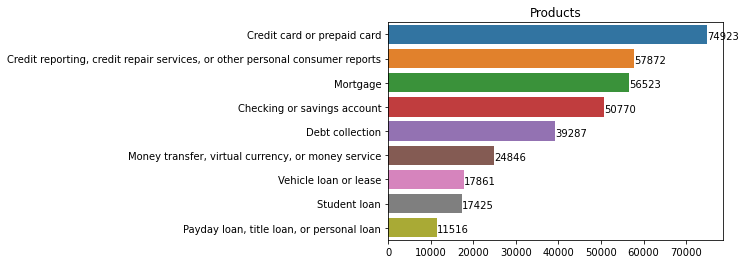

In [19]:
# Barplot for products

y = df_main.Product.value_counts().index
x = df_main.Product.value_counts().values

b1 = sns.barplot(y = y, x = x)
for i in range(len(x)):
    b1.annotate(text = x[i], xy = (x[i], i+0.2))
    
plt.title('Products')
plt.show()

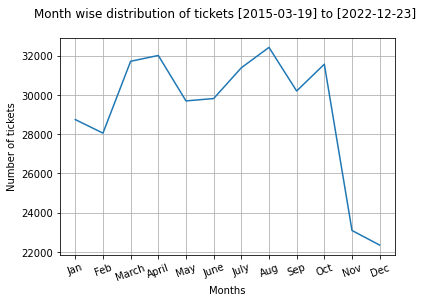

In [20]:
y = (df_main['Product'].groupby(df_main['Date received'].dt.month).count()).values
x = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
l1 = sns.lineplot(x = x, y = y, markers = True)
plt.xlabel('Months')
plt.ylabel('Number of tickets')
plt.xticks(rotation = 20)
plt.title('Month wise distribution of tickets [2015-03-19] to [2022-12-23] \n')
plt.grid('on')
plt.show()

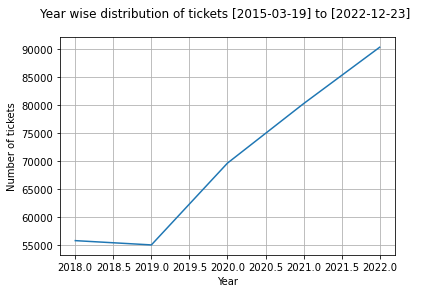

In [21]:
y = (df_main['Product'].groupby(df_main['Date received'].dt.year).count()).values
x = (df_main['Product'].groupby(df_main['Date received'].dt.year).count()).index
sns.lineplot(x = x, y = y)
plt.xlabel('Year')
plt.ylabel('Number of tickets')
plt.title('Year wise distribution of tickets [2015-03-19] to [2022-12-23] \n')
plt.grid('on')
plt.show()

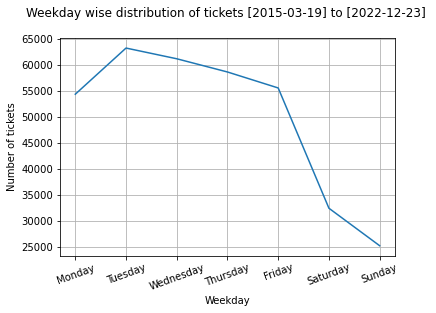

In [22]:
y = (df_main['Product'].groupby(df_main['Date received'].dt.weekday).count()).values
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.lineplot(x = x, y = y)
plt.xlabel('Weekday')
plt.xticks(rotation = 20)
plt.ylabel('Number of tickets')
plt.title('Weekday wise distribution of tickets [2015-03-19] to [2022-12-23] \n')
plt.grid('on')
plt.show()

# MultiVariate Analysis

In [23]:
# Splitting date into year, month, weekday

df_main['Year'] = df_main['Date received'].dt.year
df_main['Month'] = df_main['Date received'].dt.month
df_main['Weekday'] = df_main['Date received'].dt.weekday

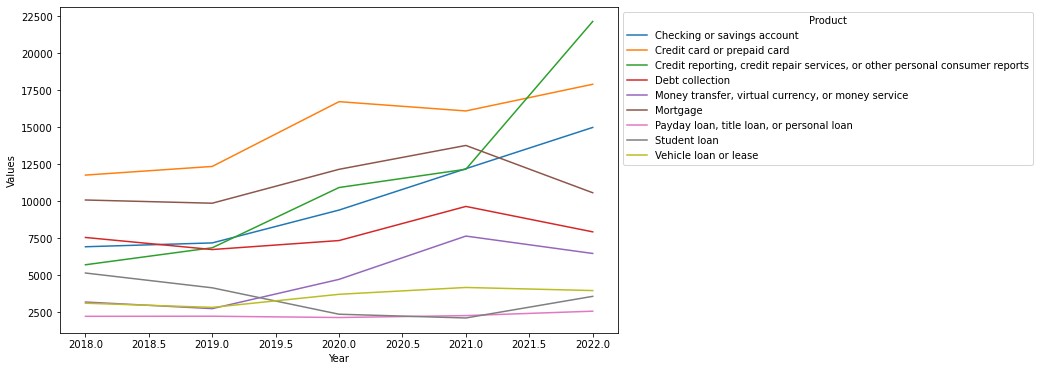

In [24]:
temp = pd.DataFrame(df_main[['Year', 'Product']].value_counts().sort_index(), columns=['Values'])
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize = (10, 6))
l = sns.lineplot(x = temp.Year, y = temp.Values, hue = temp.Product, palette = 'tab10')
sns.move_legend(l, "upper left", bbox_to_anchor = (1, 1))
plt.show()

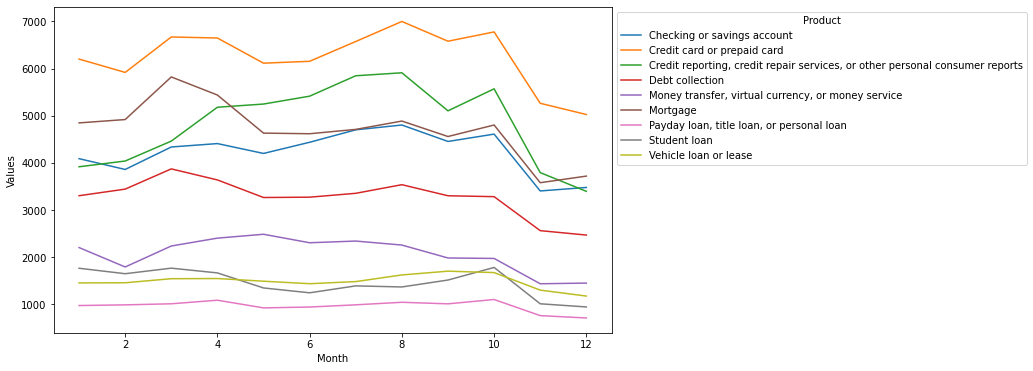

In [25]:
temp = pd.DataFrame(df_main[['Month', 'Product']].value_counts().sort_index(), columns=['Values'])
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize = (10, 6))
l = sns.lineplot(x = temp.Month, y = temp.Values, hue = temp.Product, palette = 'tab10')
sns.move_legend(l, "upper left", bbox_to_anchor = (1, 1))
plt.show()

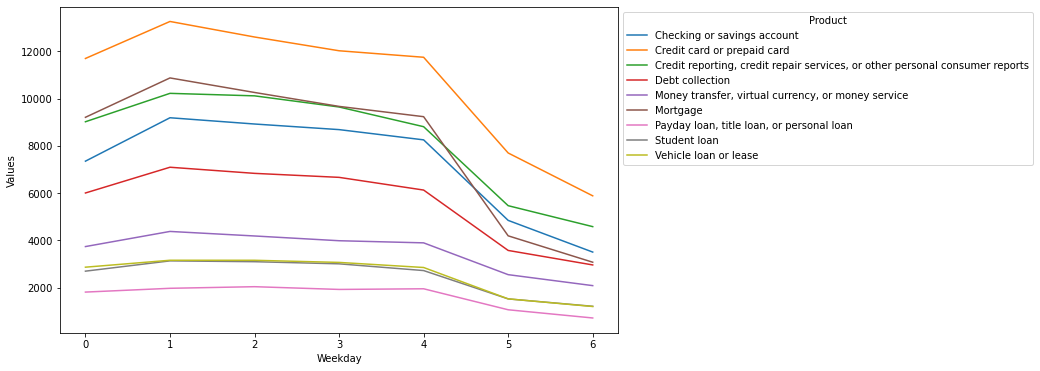

In [26]:
temp = pd.DataFrame(df_main[['Weekday', 'Product']].value_counts().sort_index(), columns=['Values'])
temp.reset_index(drop = False, inplace = True)

plt.figure(figsize = (10, 6))
l = sns.lineplot(x = temp.Weekday, y = temp.Values, hue = temp.Product, palette = 'tab10')
sns.move_legend(l, "upper left", bbox_to_anchor = (1, 1))
plt.show()

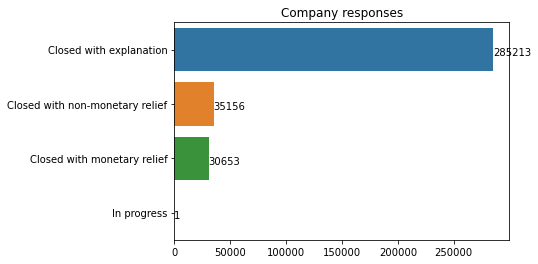

In [27]:
# BarCharts for Company responses

data = df_main['Company response to consumer'].value_counts()
b2 = sns.barplot(y = data.index, x = data.values)
for i in range(len(data.values)):
    b2.annotate(text = data.values[i], xy = (data.values[i], i+0.1))
plt.title('Company responses')
plt.show()

## Length of characters in Consumer Complaints 

In [28]:
# Length of characters in complaints

len_complaints = df_main['Consumer complaint narrative'].apply(lambda x: len(x))
df_main['len_complaints'] = len_complaints
print(f'Maximum length of complaint: {len_complaints.max()}')
print(f'Minimum length of complaint: {len_complaints.min()}')
print(f'Average length of complaint: {np.round(len_complaints.mean())}')

Maximum length of complaint: 32317
Minimum length of complaint: 4
Average length of complaint: 1252.0


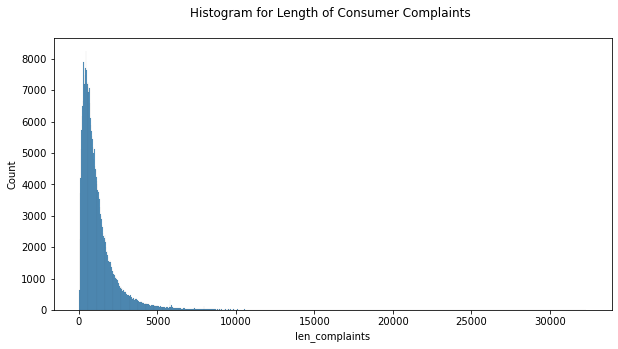

In [29]:
# Histogram for length of complaints

plt.figure(figsize= (10, 5))
sns.histplot(df_main['len_complaints'])
plt.title('Histogram for Length of Consumer Complaints \n')
plt.show()

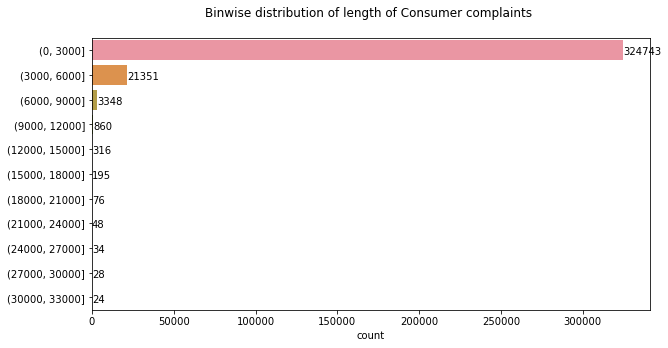

In [30]:
# Splitting the complaint length into bins

plt.figure(figsize= (10, 5))
bins = [0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000]
bins_complaints = pd.cut(df_main.len_complaints, bins = bins)

data = bins_complaints.value_counts()
c = sns.countplot(y = bins_complaints.values)

for i in range(len(data)):
    c.annotate(text = data.values[i], xy = (data.values[i], i+0.2))
plt.title('Binwise distribution of length of Consumer complaints \n')
plt.show()

## Number of Words in Consumer Complaints 

In [31]:
number_words = df_main['Consumer complaint narrative'].apply(lambda x:len(x.split(' ')))
df_main['number_words'] = number_words
print(f'Maximum number of words in consumer complaint: {number_words.max()}')
print(f'Minimum number of words in consumer complaint: {number_words.min()}')
print(f'Average number of words in consumer complaint: {np.round(number_words.mean())}')

Maximum number of words in consumer complaint: 5998
Minimum number of words in consumer complaint: 1
Average number of words in consumer complaint: 227.0


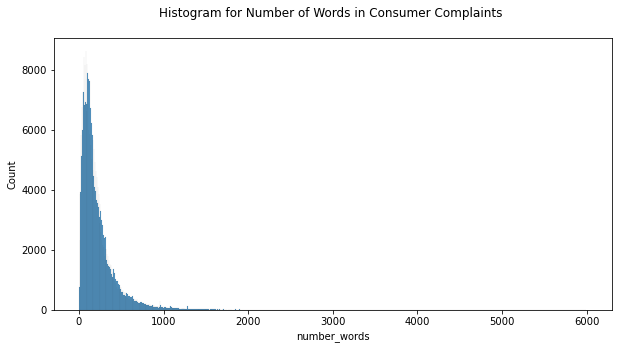

In [32]:
# Histogram for length of complaints

plt.figure(figsize= (10, 5))
sns.histplot(df_main.number_words)
plt.title('Histogram for Number of Words in Consumer Complaints \n')
plt.show()

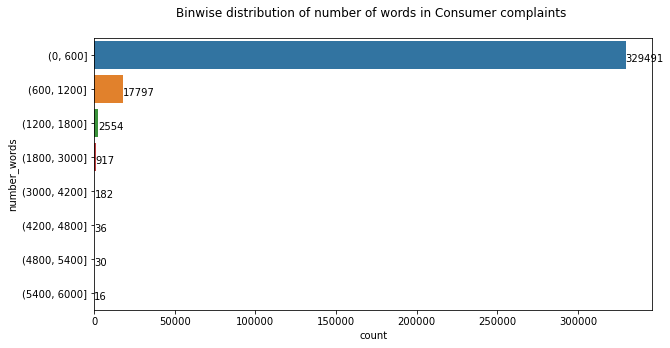

In [33]:
# Splitting the complain length into bins

plt.figure(figsize= (10, 5))
bins = [0, 600, 1200, 1800, 3000, 4200, 4800, 5400, 6000]
bins_complaints_words = pd.cut(df_main.number_words, bins = bins)

data = bins_complaints_words.value_counts()
c = sns.countplot(y = bins_complaints_words)

for i in range(len(data)):
    c.annotate(text = data.values[i], xy = (data.values[i], i+0.2))
plt.title('Binwise distribution of number of words in Consumer complaints \n')
plt.show()

# Data Preprocessing

<br>Tickets under certain products can be merged together under a common product. 
<br>Eg. 'Credit reporting' can be merged under 'Credit reporting, credit repair services, or other personal consumer reports'
<br>All loan related products can be merged under common 'Loans' product
<br>In this way total number of classes in Product feature is reduced from 9 to 7.

In [34]:
# Replacing Product names 

df_main.Product.replace('Student loan', 'Student/ Vehicle/ Personal loans', inplace = True)
df_main.Product.replace('Vehicle loan or lease', 'Student/ Vehicle/ Personal loans', inplace = True)
df_main.Product.replace('Payday loan, title loan, or personal loan', 'Student/ Vehicle/ Personal loans', inplace = True)

In [35]:
# Percentage of Product classes

np.round((df_main.Product.value_counts()/ df_main.Product.shape[0])*100,2)

Credit card or prepaid card                                                     21.34
Credit reporting, credit repair services, or other personal consumer reports    16.49
Mortgage                                                                        16.10
Checking or savings account                                                     14.46
Student/ Vehicle/ Personal loans                                                13.33
Debt collection                                                                 11.19
Money transfer, virtual currency, or money service                               7.08
Name: Product, dtype: float64

In [36]:
# Cleaning the text for model 

def clean_data(data):
    data = str(data)
    # Removing some seen patterns
    data = re.sub(r'XX' or 'XXX' or 'XXXX', '', data)
    
    # Lower Case all the words
    data = data.lower()
    
    # Replacing non-alphabetic characters with space
    data = re.sub(r'[^a-zA-Z]', ' ', data)
    
    # Removing Stopwards
    STOPWORDS = stopwords.words('english')
    data = [x for x in data.split() if x not in STOPWORDS]
    
    # Using lemmatization to convert different forms of word to same 
    lemma = WordNetLemmatizer()
    data = [lemma.lemmatize(x) for x in data]
    data = ' '.join(data)
    
    # Using only noun tagged words
    TB = TextBlob(data)
    data = [x for (x, tag) in TB.tags if tag == 'NN']
    
    return ' '.join(data)

In [ ]:
# Saving the clean_data function
pickle.dump(clean_data, open('clean_function.pickle', 'wb'))

In [37]:
%%time
# df_main['Cleaned_complaints'] = df_main['Consumer complaint narrative'].apply(clean_data)

CPU times: total: 0 ns
Wall time: 0 ns


In [38]:
# Exporting the dataset
# df_main.to_csv('Cleaned_complaints_1.csv', sep= '~', index = False)

-----------------------------------------------------------------------------------------------

# Creating Spark Session

In [39]:
# Creating SparkSession

findspark.init() #Initializing findspark

spark = SparkSession.builder.appName('Ticketing').config("spark.driver.memory", "18g").getOrCreate()
spark

In [40]:
# Importing Pandas Dataframe into spark

Schema = T.StructType().add('Date received',T.DateType(), True)\
                       .add('Product', 'string')\
                       .add('Consumer complaint narrative', 'string')\
                       .add('Company response to consumer', 'string') \
                       .add('Timely response?', 'string') \
                       .add('Year', T.IntegerType())\
                       .add('Month', T.IntegerType())\
                       .add('Weekday', T.IntegerType())\
                       .add('len_complaints', T.IntegerType())\
                       .add('number_words', T.IntegerType())\
                       .add('Cleaned_complaints', T.StringType())

# spark_df_main = spark.createDataFrame(df_main, schema = Schema)
spark_df_main = spark.read.csv('Cleaned_complaints.csv', schema = Schema, header=True, multiLine=True)

spark_df_main.show(3, truncate = False, vertical = True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
spark_df_main.printSchema()

root
 |-- Date received: date (nullable = true)
 |-- Product: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- len_complaints: integer (nullable = true)
 |-- number_words: integer (nullable = true)
 |-- Cleaned_complaints: string (nullable = true)



In [42]:
%%time
# # Creating UDF
# clean_data_udf = F.udf(f = lambda row: clean_data(row), returnType = T.StringType())

# updated_spark_df = spark_df_main.withColumn('spark_cleaned_complaints', clean_data_udf(F.col('Consumer complaint narrative')))
# updated_spark_df.show(2, truncate = False, vertical = True)

CPU times: total: 0 ns
Wall time: 0 ns


In [43]:
# Keeping non-null cleaned compliants

spark_df_main = spark_df_main.na.drop(subset = 'Cleaned_complaints')

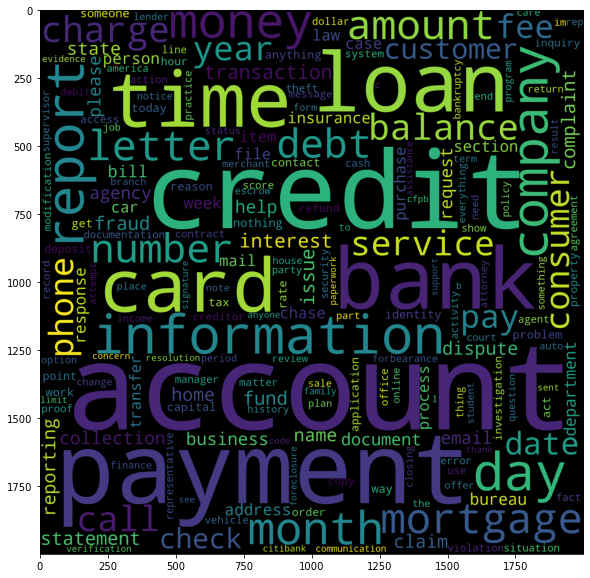

In [44]:
# Tokenizing complaints

updated_spark_df = spark_df_main.withColumn('tokenized', F.split(spark_df_main['Cleaned_complaints'],' '))
unigram_bow = updated_spark_df.select(F.explode("tokenized").alias("unigram")).groupBy('unigram').count()

frequencies = unigram_bow.toPandas().set_index('unigram').T.to_dict('records')

plt.figure(figsize=(15,10))
wordcloud_ip = WordCloud(background_color = 'black', 
                         width=2000, height=2000,
                    max_words = 200).generate_from_frequencies(dict(*frequencies))
plt.imshow(wordcloud_ip)

In [45]:
# Using NGram to generate bigrams and trigrams

ngram_df = NGram(n = 2, inputCol = 'tokenized', outputCol = 'bigrams').transform(updated_spark_df)
ngram_df = NGram(n = 3, inputCol = 'tokenized', outputCol = 'trigrams').transform(ngram_df)
ngram_df.show(2, truncate = False, vertical = True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Date received                | 2022-12-14                                                                                                                        

In [46]:
# Creating bigrams for each Product separately

label0 = ngram_df.filter(ngram_df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports')
label1 = ngram_df.filter(ngram_df['Product'] == 'Checking or savings account')
label2 = ngram_df.filter(ngram_df['Product'] == 'Credit card or prepaid card')
label3 = ngram_df.filter(ngram_df['Product'] == 'Mortgage')
label4 = ngram_df.filter(ngram_df['Product'] == 'Student/ Vehicle/ Personal loans')
label5 = ngram_df.filter(ngram_df['Product'] == 'Debt collection')
label6 = ngram_df.filter(ngram_df['Product'] == 'Money transfer, virtual currency, or money service')

----------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------

Now that we have splitted the data into train test, we will apply Classification models
1. Naive Bayes
2. Decision Tree
3. Logistic Regression
4. Random Forest

-------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------

In [47]:
# Importing cleaned dataset
df_train = pd.read_csv('Cleaned_complaints.csv')

df_train = df_train[['Product','Cleaned_complaints']] # Keeping relevant features needed for model building
df_train = df_train[df_train.Cleaned_complaints.notnull()] # Keeping non-null features
df_train.head()

,Product,Cleaned_complaints
0,Checking or savings account,youth account checking child mom account holder account charge speak mom child account charge authenticate child issue site support request etc
1,Credit card or prepaid card,charge card claim item address purchase date transaction delivery date transaction investigation letter card le year purchase store fraud issue employee affiliate fyi credit card month card ownership portion competition purchase
2,Credit card or prepaid card,citis buy credit card debt protection program enrollment response statement accurate paperless functionality view download statement work device error charge day statement transaction day transaction section site default transaction default statement charge citi try run clock percent purchase interest
3,Checking or savings account,charge change online issue debit refuse issue debit card service arm pin stop fraud charge
4,Checking or savings account,husband address problem joint account year address use credit problem bankruptcy year work deposit account husband account husband blaming attorney bankruptcy husband way asset attorney bank practice customer husband bill mortgage item care someone help unfreeze account


In [48]:
# Using Count vectorizer to transform to tokens with counts
count = CountVectorizer()

count_df_train = count.fit_transform(df_train.Cleaned_complaints)
count.vocabulary_

{'youth': 49556,
 'account': 372,
 'checking': 7849,
 'child': 7963,
 'mom': 28837,
 'holder': 21454,
 'charge': 7702,
 'speak': 41604,
 'authenticate': 3596,
 'issue': 24706,
 'site': 40872,
 'support': 43078,
 'request': 37759,
 'etc': 16332,
 'card': 6848,
 'claim': 8371,
 'item': 24754,
 'address': 800,
 'purchase': 35308,
 'date': 11932,
 'transaction': 45638,
 'delivery': 12623,
 'investigation': 24416,
 'letter': 26210,
 'le': 25972,
 'year': 49405,
 'store': 42429,
 'fraud': 18723,
 'employee': 15698,
 'affiliate': 1115,
 'fyi': 19234,
 'credit': 11163,
 'month': 28974,
 'ownership': 31856,
 'portion': 33855,
 'competition': 9415,
 'citis': 8300,
 'buy': 6334,
 'debt': 12162,
 'protection': 35022,
 'program': 34784,
 'enrollment': 15922,
 'response': 38046,
 'statement': 42113,
 'accurate': 485,
 'paperless': 32054,
 'functionality': 19118,
 'view': 47523,
 'download': 14682,
 'work': 49040,
 'device': 13217,
 'error': 16181,
 'day': 11971,
 'section': 39810,
 'default': 12365,

In [49]:
# Using tfidf to normalize and get tfidf vectors

tfidf = TfidfTransformer()
tfidf_df_train = tfidf.fit_transform(count_df_train)

In [50]:
# Dumping count vectorizer vocabulary and tfidf data 

pickle.dump(count.vocabulary_, open('count_vector.pickle', 'wb'))
pickle.dump(tfidf, open('tfidf.pickle', 'wb'))

In [51]:
# LabelEncoding Product

lb = LabelEncoder()
df_train['label'] = lb.fit_transform(df_train.Product)

In [52]:
# Creating labels Dictionary

labels_dict_pandas = {}
for i in range(7):
    labels_dict_pandas[i] = lb.classes_[i]
labels_dict_pandas

pickle.dump(labels_dict_pandas, open('labels_dict_pandas.pickle', 'wb'))

In [53]:
# Splitting the dataset into train test

x_train, x_test, y_train, y_test = train_test_split(tfidf_df_train, df_train.label, test_size = 0.3, random_state = 1)

print(f'x_train Shape: {x_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'x_test Shape: {x_test.shape}')
print(f'y_test Shape: {y_test.shape}')

x_train Shape: (245662, 49686)
y_train Shape: (245662,)
x_test Shape: (105284, 49686)
y_test Shape: (105284,)


## Naive Bayes MultiNominal Model:


Test Accuracy Score using Naive Bayes: 79.0 %


Train Accuracy Score using Naive Bayes: 80.0 %

Classification Report using Naive Bayes:

                                                                               precision    recall  f1-score   support

                                                 Checking or savings account       0.79      0.71      0.75     17165
                                                 Credit card or prepaid card       0.77      0.79      0.78     21770
Credit reporting, credit repair services, or other personal consumer reports       0.78      0.78      0.78     17494
                                                             Debt collection       0.69      0.75      0.72     10892
                          Money transfer, virtual currency, or money service       0.66      0.74      0.70      6698
                                                                    Mortgage       0.93      0.91      0.92     17445
                                 

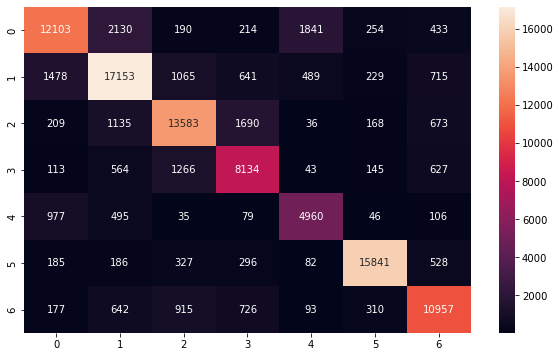

AUC Score using Naive Bayes: 0.9597083479831209


In [54]:
plt.figure(figsize = (10,6))

mnb = MultinomialNB() # Initiating the model 

params_grid = {'alpha' : [0.05, 0.1, 0.4, 0.8, 1],
               'fit_prior' : [True, False]
              }

# Hyper parameter tuning 
grid_mnb = GridSearchCV(estimator = mnb, param_grid = params_grid, cv = 5, n_jobs = -1)
grid_mnb.fit(x_train, y_train)

# Using optimum parameters to build the model
best_mnb_model = MultinomialNB(alpha = grid_mnb.best_params_['alpha'], fit_prior = grid_mnb.best_params_['fit_prior'])

best_mnb_model.fit(x_train, y_train) # Fitting best model to training data
mnb_pred = best_mnb_model.predict(x_test) # Predicting the output using test data

# ------------------------------------------------------------------------------------------------
# Checking the model performance 

#Accuracy Score
mnb_test_accuray = accuracy_score(mnb_pred, y_test)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Test Accuracy Score using Naive Bayes:{bcolors.ENDC} {np.round(mnb_test_accuray, 2)*100} %\n')
mnb_train_accuray = accuracy_score(best_mnb_model.predict(x_train), y_train)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Train Accuracy Score using Naive Bayes:{bcolors.ENDC} {np.round(mnb_train_accuray, 2)*100} %\n')


# Classification Report
mnb_classification_report = classification_report(mnb_pred, y_test, target_names = list(labels_dict_pandas.values()))
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Classification Report using Naive Bayes:{bcolors.ENDC}\n\n {mnb_classification_report} \n')

# Confusion Matrix
mnb_confusion = confusion_matrix(mnb_pred, y_test)
heatmap = sns.heatmap(mnb_confusion, annot = True, fmt = "d");
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Confusion Matrix using Naive Bayes:{bcolors.ENDC}\n\n {heatmap} \n')
plt.show()

#F1_Score
mnb_f1_score = f1_score(mnb_pred, y_test, average = 'micro')

#ROC Curve
mnb_roc_curve = roc_auc_score(y_test, best_mnb_model.predict_proba(x_test), multi_class = 'ovr', average ='macro')
print(f'{bcolors.OKBLUE}{bcolors.BOLD}AUC Score using Naive Bayes:{bcolors.ENDC} {mnb_roc_curve}')

## Logisitc Regression 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 1}

Test Accuracy Score using Logistic Regression: 82.0 %


Train Accuracy Score using Logistic Regression: 83.0 %

Classification Report using Logistic Regression:

                                                                               precision    recall  f1-score   support

                                                 Checking or savings account       0.80      0.76      0.78     16042
                                                 Credit card or prepaid card       0.84      0.81      0.82     23128
Credit reporting, credit repair services, or other personal consumer reports       0.81      0.79      0.80     17875
                                                             Debt collection       0.73      0.78      0.76     11057
                          Money transfer, virtual currency, or money service       0.68      0.79      0.73      6509
                                                          

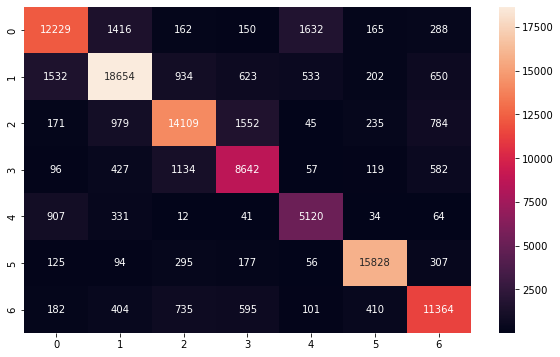

AUC Score using Logistic Regression: 0.9689961925789936
CPU times: total: 27.3 s
Wall time: 2min 11s


In [55]:
%%time
plt.figure(figsize = (10,6))


lr = LogisticRegression(penalty = 'l2', solver = 'saga') # Initiating the model 

params_grid = {'C' : [0.001, 0.01, 0.1, 1]}

# Hyper parameter tuning 
grid_lr = GridSearchCV(estimator = lr, param_grid = params_grid, cv = 5, n_jobs = -1, verbose = 1)
grid_lr.fit(x_train, y_train)
print(grid_lr.best_params_)

# Using optimum parameters to build the model
best_lr_model = LogisticRegression(penalty = 'l2', solver = 'saga', C = grid_lr.best_params_['C'])

best_lr_model.fit(x_train, y_train) # Fitting best model to training data
lr_pred = best_lr_model.predict(x_test) # Predicting the output using test data

# ------------------------------------------------------------------------------------------------
# Checking the model performance 

#Accuracy Score
lr_test_accuray = accuracy_score(lr_pred, y_test)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Test Accuracy Score using Logistic Regression:{bcolors.ENDC} {np.round(lr_test_accuray, 2)*100} %\n')
lr_train_accuray = accuracy_score(best_lr_model.predict(x_train), y_train)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Train Accuracy Score using Logistic Regression:{bcolors.ENDC} {np.round(lr_train_accuray, 2)*100} %\n')


# Classification Report
lr_classification_report = classification_report(lr_pred, y_test, target_names = list(labels_dict_pandas.values()))
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Classification Report using Logistic Regression:{bcolors.ENDC}\n\n {lr_classification_report} \n')

# Confusion Matrix
lr_confusion = confusion_matrix(lr_pred, y_test)
heatmap = sns.heatmap(lr_confusion, annot = True, fmt = "d");
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Confusion Matrix using Logistic Regression:{bcolors.ENDC}\n\n {heatmap} \n')
plt.show()

#F1_Score
lr_f1_score = f1_score(lr_pred, y_test, average = 'micro')

#ROC Curve
lr_roc_curve = roc_auc_score(y_test, best_lr_model.predict_proba(x_test), multi_class = 'ovr', average ='macro')
print(f'{bcolors.OKBLUE}{bcolors.BOLD}AUC Score using Logistic Regression:{bcolors.ENDC} {lr_roc_curve}')

## Support Vector Machine


Test Accuracy Score using SVC: 82.0 %
Train Accuracy Score using SVC: 83.0 %

Classification Report using SVC:

                                                                               precision    recall  f1-score   support

                                                 Checking or savings account       0.80      0.76      0.78     16176
                                                 Credit card or prepaid card       0.84      0.80      0.82     23347
Credit reporting, credit repair services, or other personal consumer reports       0.80      0.80      0.80     17593
                                                             Debt collection       0.73      0.79      0.76     10906
                          Money transfer, virtual currency, or money service       0.66      0.79      0.72      6355
                                                                    Mortgage       0.93      0.93      0.93     17015
                                            Student/ Vehicl

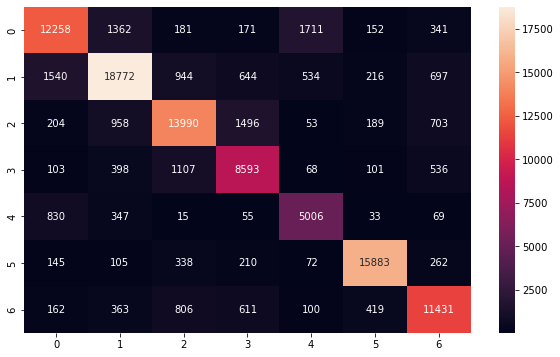

AUC Score using SVC: 0.9671714674149255
CPU times: total: 39.3 s
Wall time: 36.3 s


In [56]:
%%time
plt.figure(figsize = (10,6))

# svc = LinearSVC() # Initiating the model 

# params_grid = {'penalty': ['l1', 'l2'],
#                'C' : [0.001, 0.01, 0.1, 1, 10]
#               }

# # Hyper parameter tuning 
# grid_svc = GridSearchCV(estimator = svc, param_grid = params_grid, cv = 5, n_jobs = -1, verbose = 3)
# grid_svc.fit(x_train, y_train)
# print(grid_svc.best_params_)

# Using optimum parameters to build the model
best_svc_model = LinearSVC(penalty = 'l2', C = 0.1 )

best_svc_model.fit(x_train, y_train) # Fitting best model to training data
svc_pred = best_svc_model.predict(x_test) # Predicting the output using test data

# ------------------------------------------------------------------------------------------------
# Checking the model performance 

#Accuracy Score
svc_test_accuray = accuracy_score(svc_pred, y_test)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Test Accuracy Score using SVC:{bcolors.ENDC} {np.round(svc_test_accuray, 2)*100} %')
svc_train_accuray = accuracy_score(best_svc_model.predict(x_train), y_train)
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Train Accuracy Score using SVC:{bcolors.ENDC} {np.round(svc_train_accuray, 2)*100} %\n')

# Classification Report
svc_classification_report = classification_report(svc_pred, y_test, target_names = list(labels_dict_pandas.values()))
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Classification Report using SVC:{bcolors.ENDC}\n\n {svc_classification_report} \n')

# Confusion Matrix
svc_confusion = confusion_matrix(svc_pred, y_test)
heatmap = sns.heatmap(svc_confusion, annot = True, fmt = "d");
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Confusion Matrix using SVC:{bcolors.ENDC}\n\n {heatmap} \n')
plt.show()

#F1_Score
svc_f1_score = f1_score(svc_pred, y_test, average = 'micro')

clf = CalibratedClassifierCV(best_svc_model)
clf.fit(x_train, y_train)
#ROC Curve
svc_roc_curve = roc_auc_score(y_test, clf.predict_proba(x_test), multi_class = 'ovr', average ='macro')
print(f'{bcolors.OKBLUE}{bcolors.BOLD}AUC Score using SVC:{bcolors.ENDC} {svc_roc_curve}')

## Decision Tree


Test Accuracy Score using Decision Tree: 73.0 %


Train Accuracy Score using Decision Tree: 76.0 %

Classification Report using Decision Tree:

                                                                               precision    recall  f1-score   support

                                                 Checking or savings account       0.72      0.63      0.67     17284
                                                 Credit card or prepaid card       0.78      0.68      0.73     25438
Credit reporting, credit repair services, or other personal consumer reports       0.71      0.76      0.73     16298
                                                             Debt collection       0.63      0.75      0.68      9877
                          Money transfer, virtual currency, or money service       0.51      0.65      0.57      5897
                                                                    Mortgage       0.86      0.89      0.87     16309
                           

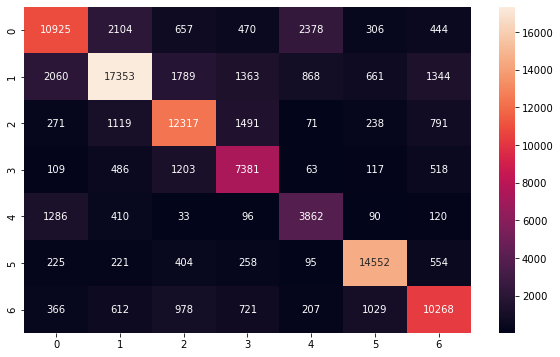

AUC Score using Decision Tree: 0.9299133577971865
CPU times: total: 2min 11s
Wall time: 2min 13s


In [57]:
%%time
plt.figure(figsize = (10,6))

dt = DecisionTreeClassifier() # Initiating the model 

# params_grid = {'criterion': ['gini'],
#                'max_depth' : [10, 15, 20, 25],
#                'min_samples_leaf':[10,15, 20, 25]
#               }

# # Hyper parameter tuning 
# grid_dt = GridSearchCV(estimator = dt, param_grid = params_grid, cv = 5, n_jobs = -1, verbose = 3)
# grid_dt.fit(x_train, y_train)
# print(grid_dt.best_params_)

# Using optimum parameters to build the model
best_dt_model = DecisionTreeClassifier(criterion = 'gini', 
                                       max_depth = 25,
                                       min_samples_leaf = 25
                                      )

best_dt_model.fit(x_train, y_train) # Fitting best model to training data
dt_pred = best_dt_model.predict(x_test) # Predicting the output using test data

# ------------------------------------------------------------------------------------------------
# Checking the model performance 

#Accuracy Score
dt_test_accuray = accuracy_score(dt_pred, y_test)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Test Accuracy Score using Decision Tree:{bcolors.ENDC} {np.round(dt_test_accuray, 2)*100} %\n')
dt_train_accuray = accuracy_score(best_dt_model.predict(x_train), y_train)
print(f'\n{bcolors.OKBLUE}{bcolors.BOLD}Train Accuracy Score using Decision Tree:{bcolors.ENDC} {np.round(dt_train_accuray, 2)*100} %\n')


# Classification Report
dt_classification_report = classification_report(dt_pred, y_test, target_names = list(labels_dict_pandas.values()))
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Classification Report using Decision Tree:{bcolors.ENDC}\n\n {dt_classification_report} \n')

# Confusion Matrix
dt_confusion = confusion_matrix(dt_pred, y_test)
heatmap = sns.heatmap(dt_confusion, annot = True, fmt = "d");
print(f'{bcolors.OKBLUE}{bcolors.BOLD}Confusion Matrix using Decision Tree:{bcolors.ENDC}\n\n {heatmap} \n')
plt.show()

#F1_Score
dt_f1_score = f1_score(dt_pred, y_test, average = 'micro')

#ROC Curve
dt_roc_curve = roc_auc_score(y_test, best_dt_model.predict_proba(x_test), multi_class = 'ovr', average ='macro')
print(f'{bcolors.OKBLUE}{bcolors.BOLD}AUC Score using Decision Tree:{bcolors.ENDC} {dt_roc_curve}')

## Comparing the Performance Metrics 

In [58]:
# Creating Performance Metrics DataFrame

metrics = pd.DataFrame([], columns = ['Model', 'Train_Accuracy', 'Test_Accuracy', 'F1_Score', 'AUC_Score'])

metrics['Model'] = ['Naive Bayes', 'Logistic Regression', 'Linear SVM', 'Decision Tree']
metrics['Train_Accuracy'] = [mnb_train_accuray, lr_train_accuray, svc_train_accuray, dt_train_accuray]
metrics['Test_Accuracy'] = [mnb_test_accuray, lr_test_accuray, svc_test_accuray, dt_test_accuray]
metrics['F1_Score'] = [mnb_f1_score, lr_f1_score, svc_f1_score, dt_f1_score]
metrics['AUC_Score'] = [mnb_roc_curve, lr_roc_curve, svc_roc_curve, dt_roc_curve]

metrics

,Model,Train_Accuracy,Test_Accuracy,F1_Score,AUC_Score
0,Naive Bayes,0.801679,0.785789,0.785789,0.959708
1,Logistic Regression,0.834415,0.816325,0.816325,0.968996
2,Linear SVM,0.830096,0.816202,0.816202,0.967171
3,Decision Tree,0.761392,0.728107,0.728107,0.929913


After Comparing all the models, Logistic Regression gives the best results with:
1. Test accuracy = 81.6 %
2. F1_Score = 0.816
3. AUC_score = 0.97

In [67]:
# Saving Logistic Regression model 
pickle.dump(best_lr_model, open('lr_model.pickle', 'wb'))

## Testing on Data

In [103]:
import dill

dill_clean_func = dill.dumps(clean_data)
           
pickle.dump(dill_clean_func, open('dill_clean_func.pickle', 'wb'))

In [93]:
# Reading all necessary pickle files 

vocab = pickle.load(open('count_vector.pickle', 'rb'))
Products_labels = pickle.load(open('labels_dict_pandas.pickle', 'rb'))
tfidf_fit = pickle.load(open('tfidf.pickle', 'rb'))
model = pickle.load(open('lr_model.pickle', 'rb'))
clean_complaints_func = pickle.load(open('clean_function.pickle', 'rb'))

In [90]:
def predict(data):
    cleaned_complaint_test1 = clean_complaints_func(data)
    count_vector_test1 = CountVectorizer(vocabulary = vocab)
    vectored_data = count_vector_test1.transform([cleaned_complaint_test1])
    tfidf_test1 = tfidf_fit.transform(vectored_data)
    predict_test1 = model.predict(tfidf_test1)
    
    return Products_labels[predict_test1[0]]

In [97]:
## Testing on data from df_aux dataframe

test1 = df_aux['Consumer complaint narrative'].to_list()[4]
predict(test1)

'Student/ Vehicle/ Personal loans'

In [104]:
test1

'I would like to file a formal complaint against Giggle Finance based in XXXX, FL. Giggle Finance is a company that gives short term loans to help XXXX XXXX with their business expenses. However, the terms of the " loan \'\' are not very clear. From my understanding they lend money in exchange for future revenue from your business that is paid in weekly payments. I applied for {$500.00} and when the money was deposited the origination fee was automatically debited so I did not receive the full {$500.00} that I originally was approved for. The company is known to be a predatory lender with very high and confusing interest rate amounts. I recently contacted the company after an issue with their system caused a payment to not be withdrawn. The problem was corrected and then I requested a copy of all payments that I have made up until now ; which the company complied with. However, when the company sent the information over to me they told me that they can legally report missed payments af